In [1]:
import requests, bs4, time, os, re, random
import numpy as np
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from autocorrect import spell
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
#so many imports

In [2]:
well_api_number=[30015215980000,30015256300000] #api numbers of the wells you want to download
where_I_want_the_files=r'D:/NM logs/' #change this line to your file path

In [ ]:
#this cell is the portion that downloads the files from the website
#the section that needs to be changed is the variable newpath. Change it to wherever you want the documents saved on your drive
number_of_files=[]
for well in well_api_number:
    newpath = ((r'D:/NM logs/%s') % (well)) #change this line to your file path
    if not os.path.exists(newpath): os.makedirs(newpath) #check to see if the path exists, if not it creates it
    response1 = requests.get('http://ocdimage.emnrd.state.nm.us/imaging/WellFileView.aspx?RefType=WF&RefID='+str(well)) #scrapes the individual well docs page
    soup2=bs4.BeautifulSoup(response1.text, "lxml") #website response as text data
    links=[] 
    for a in soup2.find_all('a', href=True): #scrape all the links from the page and add to a list
        links.append(a['href'])
    links=links[8:-3]
    number_of_files.append(len(links)) #a count of the number of files being downloaded
    for i in range(len(links)-1): #the actual portion that opens the links and saves the documents as pdf
        try:
            r=requests.get(links[i])
            with open(str(where_I_want_the_files)+str(well)+'/file'+str(i)+'.pdf',"wb") as pdf: #change this line to whatever your path is 
                for chunk in r.iter_content(chunk_size=1024):
                    if chunk:
                        pdf.write(chunk)
        
        except:
            pass

In [ ]:
from __future__ import print_function
from wand.image import Image
#more imports that are only used in this cell
#this cell converts the pdf files into jpeg files and places them in a folder called images within your dir

for well in range(len(well_api_number)):
    Path = str(where_I_want_the_files)+str(well_api_number[well])
    number_of_files = len(os.listdir(Path)) #counts number of pdf files to process
    for items in range(number_of_files-1):
        newpath = (str(where_I_want_the_files)+str(well_api_number[well])+'/images') 
        if not os.path.exists(newpath): os.makedirs(newpath)
        with Image(filename=str(where_I_want_the_files)+str(well_api_number[well])+'/file'+str(items)+'.pdf', resolution=600) as img:
            #print('pages = ', len(img.sequence))
            with img.convert('jpg') as converted:
                converted.save(filename='D:/NM logs/'+str(well_api_number[well])+'/images/page-'+str(items)+'.jpg') #saves the images

In [ ]:
import pytesseract
from pytesseract import image_to_string
from ipywidgets import FloatProgress
from IPython.display import display
#more imports used in this cell only

f = FloatProgress(min=0, max=100)
display(f)
#because progress bars are nice

tessdata_dir_config = '--tessdata-dir "C:\\Program Files (x86)\\Tesseract-OCR\\tessdata"' #pytesseract is a pain, find these folders
pytesseract.pytesseract.tesseract_cmd = 'C:\\Program Files (x86)\\Tesseract-OCR\\tesseract.exe' #set these values equal to the path with these folders

wellDocument=[]
documents=[]
from PIL import Image
#one last import of PIL

for well in range(len(well_api_number)):
    documents=[]
    Path = str(where_I_want_the_files)+str(well_api_number[well])+'\\images'
    number_of_files = len(os.listdir(Path))

    for items in range(number_of_files-1):
        f.value += 1

        try:
            im=Image.open(str(where_I_want_the_files)+str(well_api_number[well])+'\\images\\page-'+str(items)+'.jpg', 'r') #open image
            text=image_to_string(im, config=tessdata_dir_config) #run OCR on the image
            documents.append(text) #append the text to a list
        except:
            try:
                for i in range(10): #because of naming conventions this section is needed
                    im=Image.open(str(where_I_want_the_files)+str(well_api_number[well])+'\\images\\page-'+str(items)+'-'+str(i)+'.jpg', 'r')
                    text=image_to_string(im, config=tessdata_dir_config)
                    documents.append(text)
            except:
                pass
    wellDocument.append(documents)    

In [ ]:
documents=wellDocument[0] #here we are only interested in classifying one well so we select the first wells doc data

f = FloatProgress(min=0, max=100)
display(f)
punctuations = ['(',')',';',':','[',']',',', '.', '_', '~', '...', '\\', '/'] #if you find more weird characters to munge add them
stop_words = stopwords.words('english')

autocorrectWords=[]
mungedDocuments=[]


for j in range(len(wellDocument[0])): #time to munge the text data
    f.value += 1
    autocorrectWords=[]
    tokenWords=word_tokenize(documents[j])  #tokenize each document in the document array
    keywordsDocuments = [word for word in tokenWords if not word in stop_words and  not word in punctuations] #extract keywords and remove stop words and punctuation
    for i in range(len(keywordsDocuments)): #take keywords and run them through an autocorrect method
        autocorrectWords.append(spell(keywordsDocuments[i])) #add the respelled words to a new array
    bitClean=' '.join(autocorrectWords) #turn the array back into a string
    ready=''.join([i if ord(i) < 128 else ' ' for i in bitClean]) #get rid of non unicode characters
    uniEncodedWords=ready.encode('UTF-8') #encode to bytes
    mungedDocuments.append(uniEncodedWords) #add document keywords to a new array now that they are clean and spelled correctly
#the documents you want are now assigned to the var mungedDocuments

We have munged the data, now let's build some training data for classification

In [113]:
lines=[]
Path = "D:\\NM logs\\training\\" #I have included all the .txt files in the repository, direct this path to the training folder
filelist = os.listdir(Path)
for i in filelist: #opens all the text files and adds them to the lines array
    if i.endswith(".txt"):  
        with open(Path + i, 'r') as f:
            lines.append(f.read().splitlines())

formNames = ['.'.join(x.split('.')[:-1]) for x in os.listdir(Path) if os.path.isfile(os.path.join(Path, x))] #this is a list of the form names used to name files later on

In [114]:
all_keys=[]
clean=[]

for k in range(len(lines)): #similar to what we did for the OCR documents, munging, tokenizing, and keywords for training
    str1 =' '.join(lines[k])
    clean=''.join([i if ord(i) < 128 else ' ' for i in str1])
    clean=re.sub("_", "", clean)
    tokens=word_tokenize(clean)
    keywords = [word for word in tokens if not word in stop_words and  not word in punctuations]
    all_keys.append(keywords)


In [115]:
'''
This section builds a training set from blank forms downloaded from the OCD website. Because it would take a lot of time to
build a training set by hand and because I am lazy and not getting paid for this, we are making a larger training set from
a sparse dataset. What this cell does is it takes the text from the forms and randomly selects 75% of the words on each iteration
and makes that a training example. A better option would be to classify a few hundred OCR documents by hand and use that in 
addition, but again, I'm lazy and this is more a proof of concept.
'''
Y_train=[]
training_samples=[]
for j in range(len(all_keys)):
    for i in range(75):
        training_samples.append(" ".join(random.sample(all_keys[j],int(np.round(len(all_keys[j])*.75)))))
    Y_train.append(np.full(75,j))

In [116]:
#Take word counts of the training data and convert it into a large vector
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(training_samples)
X_train_counts.shape

(3450, 1961)

In [117]:
#transform the training counts
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

(3450, 1961)

In [118]:
#these are the classes generated for the training data
Y_train=np.asarray(Y_train).flatten()

In [119]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(X_train_tfidf, Y_train) #train the model

In [120]:
X_new_counts = count_vect.transform(mungedDocuments) #test data word counts
X_new_tfidf = tfidf_transformer.transform(X_new_counts) #test data word counts transformed
predicted = clf.predict(X_new_tfidf) #predictions for classes of each document

In [121]:
#now comes the fun part of renaming the image files
#this cell takes the classes for each image and renames each image according to the predicted class

imagesPath=str(where_I_want_the_files)+str(well_api_number[0])+'/images'
files = os.listdir(imagesPath)
i = 0

for file in files:
    try:
        os.rename(os.path.join(imagesPath, file), os.path.join(imagesPath, formNames[predicted[i]]+'.jpg'))
    except:
        try:
            os.rename(os.path.join(imagesPath, file), os.path.join(imagesPath, formNames[predicted[i]]+' ('+str(i)+').jpg'))
        except:
            pass

        
    i+=1

This section looks at classification accuracy on the training data

In [204]:
#build a test set
f = FloatProgress(min=0, max=100)
display(f)
run=[]

for k in np.arange(0,1.0,.01): #k controls the percentage of words taken for each iteration in training
    Y_test=[]
    testing_samples=[]
    f.value +=1
    for j in range(len(all_keys)):
        for i in range(10):
            testing_samples.append(" ".join(random.sample(all_keys[j],int(np.round(len(all_keys[j])*k)))))
        Y_test.append(np.full(10,j))
    X_test_counts = count_vect.transform(testing_samples)
    X_test_tfidf = tfidf_transformer.transform(X_test_counts)
    predicted = clf.predict(X_test_tfidf)
    Y_test_target=np.asarray(Y_test).flatten()
    run.append(np.mean(predicted == Y_test_target))

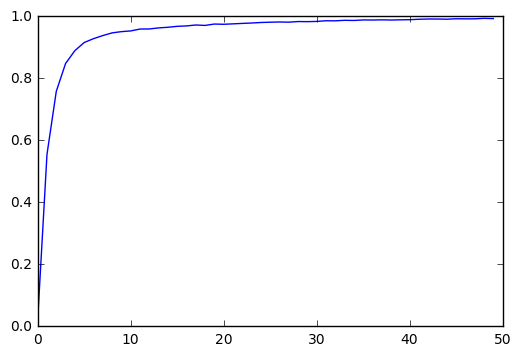

In [205]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(run)

In [201]:
from sklearn import metrics
print(metrics.classification_report(Y_test_target, predicted))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00        50
          1       1.00      1.00      1.00        50
          2       1.00      1.00      1.00        50
          3       1.00      1.00      1.00        50
          4       1.00      1.00      1.00        50
          5       1.00      1.00      1.00        50
          6       1.00      1.00      1.00        50
          7       1.00      1.00      1.00        50
          8       1.00      1.00      1.00        50
          9       1.00      1.00      1.00        50
         10       1.00      1.00      1.00        50
         11       1.00      0.98      0.99        50
         12       0.73      0.54      0.62        50
         13       0.64      0.72      0.68        50
         14       1.00      0.96      0.98        50
         15       0.60      0.82      0.69        50
         16       0.76      0.64      0.70        50
         17       1.00      1.00      1.00   